In [2]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Spatial Regression for richness of certain taxon
---
Abstraction dashboard for the joininig the data with the model

***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses fromtop to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Developer's note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stable Fix: 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


In [3]:
## Let's pick the bats node
bats = pickNode(Order,name='Chiroptera')

In [4]:
ids4bats = bats.getCellsById()

## Random selection of cells.

> Note: Data Arquitecture. For storage reasons I couldn't load the complete world bioclimatic layers. Therefore I needed to put a regional subset that comprises only the Mexican Territory. 
For this reason, it is necessary that any approach for selecting subsamples needs to be constrained (filter) by this geometry. 
We can do that with this:

Obtain list of cells within the Mexican Territory.
> The attribute: `mexican_cells.values` is a generator of the Type: QuerySet. We need to cast it to list for loading all the data in memory.


In [6]:
# Get all cell ids
#selected_cells = mexican_cells
selected_cells = ids4bats
#ids = list(selected_cells.values('pk'))

The UniformRandomCellSample is a method for sampling cells in the example below we give as arguments. 

## Extract richness and Environmental covariates from cells at a given taxonomic level
Options are: Family, Order, Spicies, etc

In [7]:
from traversals import strategies as st

In [8]:
from traversals import sampling as sm

In [9]:
sample_cells = sm.UniformRandomCellSample(ids4bats,bats.is_in.related_class,sample_size=200)

INFO Compiling Query and asking the Graph Database
INFO:biospytial.graph_models:Compiling Query and asking the Graph Database


In [10]:
import traversals.strategies as st

In [11]:
%time data = st.getEnvironmentalCovariatesFromListOfCells(sample_cells)

CPU times: user 22.4 s, sys: 292 ms, total: 22.7 s
Wall time: 2min 40s


In [12]:
%time coords = st.getCentroidsFromListofCells(sample_cells)

CPU times: user 21.1 s, sys: 320 ms, total: 21.4 s
Wall time: 32.9 s


### Build the trees from these cells
Using the function for building cell to tree cells to trees

In [13]:
from drivers.tree_builder import buildTreeNeo

In [14]:
cells = list(sample_cells)

In [15]:
trees = map(lambda c : buildTreeNeo(c),cells)

DEBUG [Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG:biospytial.graph_models:[Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG [Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG:biospytial.graph_models:[Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG [Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG:biospytial.graph_models:[Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG [Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG:biospytial.graph_models:[Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG [Developer]: check that the Occurrences are the same that in the has_occurrences method
DEBUG:biospytial.graph_models:[Developer]: check that the 

In [ ]:
## We need to calculate the big tree to get the frequencies
## This works but takes a lot of time.

#big_tree = reduce(lambda a,b : a + b ,trees)
#ocs = reduce(lambda a,b : a + b ,map(lambda t : t.occurrences, trees))

In [ ]:
## Ohh! super fast
#%time bigtree = TreeNeo(ocs,cell_objects=cells)

## Here we will get the richness for all bats

In [16]:
bats_richness_per_cell = map(lambda tree :tree.to_Animalia.to_Chordata.to_Mammalia.to_Chiroptera.richness,trees )

In [17]:
bats_richness_per_cell = pd.DataFrame({'bats_rich' : bats_richness_per_cell})

In [18]:
datafull = pd.concat([bats_richness_per_cell,coords,data],axis=1)

In [19]:
datafull.loc[:10]

,bats_rich,Longitude,Latitude,Elevation_mean,MaxTemperature_mean,MeanTemperature_mean,MinTemperature_mean,Precipitation_mean,SolarRadiation_mean,Vapor_mean,WindSpeed_mean
0,8,-106.177563,28.768390,1567.78,26.0403,17.1597,26.0972,35.037,18133.3,1.13889,2.79861
1,16,-99.023563,22.104390,188.667,30.6722,24.7917,30.7222,104.8,17944.4,2.41667,1.33333
2,1,-102.110563,21.810390,1999.22,25.7854,16.8681,25.75,43.1065,18453,1,2.41667
3,2,-94.760563,16.567390,38,31.8995,27.1111,32.0231,88.419,17597.5,2.58333,3.63426
4,53,-95.397569,16.077396,38.2222,33.6868,28.0417,33.7292,71.5995,17844.3,2.57176,4.17593
5,1,-92.408563,15.195390,409,31.2139,25.4556,31.275,218.014,18731.9,2.44722,2.15833
6,5,-95.740563,18.429390,4.88889,30.6456,25.6667,30.6556,120.758,16231.8,2.58333,2.88333
7,1,-115.634563,30.875390,1016.22,23.4681,15.5926,23.5394,18.9676,19180.5,1.2338,2.65046
8,20,-98.925563,18.919390,1547.78,28.8359,21.5208,28.8611,78.7569,18034.2,1.47685,1.84028
9,1,-95.152563,16.567390,105.333,32.2495,27.2546,32.294,70.3588,17459.5,2.58333,3.45602


In [ ]:
### Let's save it for posterior use
datafull.to_csv('/outputs/bats_richness.csv')

In [20]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [21]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


### Obtaining everything

In [22]:
datadict = { key : RasterData(models[key],border=Mexico.geom) for key,value in models.iteritems()}

In [23]:
#from django.db import connections
#connections.close_all()

In [64]:
## Without resamling (whole data)
pixel_size = 0.25
%time datacube_field = map(lambda raster : raster.rescale(pixel_size),datadict.itervalues())
datacube = datacube_field

CPU times: user 540 ms, sys: 36 ms, total: 576 ms
Wall time: 5min 30s


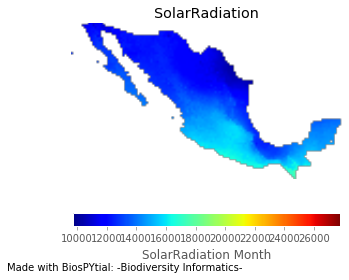

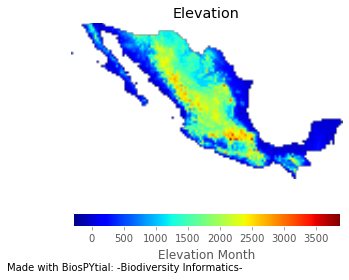

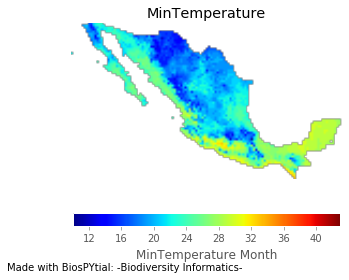

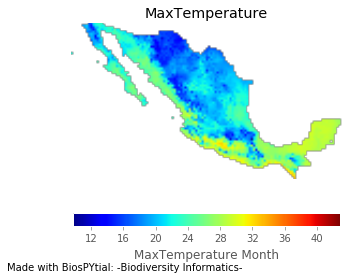

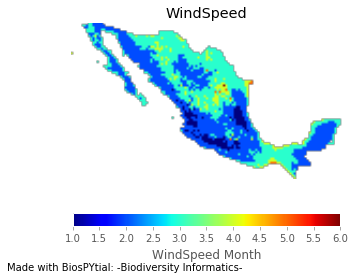

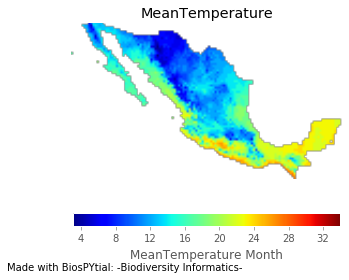

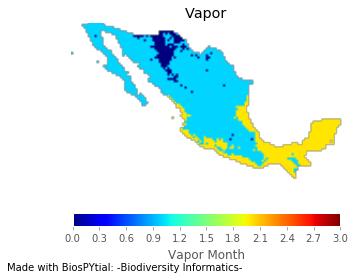

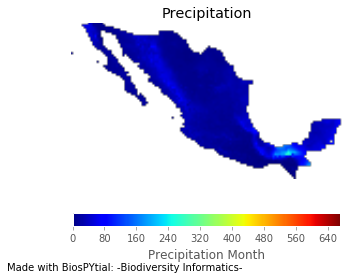

[None, None, None, None, None, None, None, None]

In [65]:
map(lambda (k,d) : d.display_field(title=k,origin='Lower'),datadict.iteritems())

## For the moment we don't want to do temporal analysis so we need to aggregate the array by the mean.

Using the new 'resample' method

In [66]:
# Take mean of evetything
cubes = map(lambda (k,v): np.mean(v.toNumpyArray(),axis=0), datadict.iteritems())

The coordinates are the same so, we can extract the them with getCoordinates and then append everything as a flat array

In [67]:
coords = map(lambda (k,v) : v.getCoordinates(),datadict.iteritems())

In [68]:
coords = pd.concat(coords,axis=1)

In [69]:
coords1 = coords[[0,1]]

In [70]:
## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)

In [71]:
datacube = pd.concat(dataframe_cube,axis=1)

In [72]:
datacube = pd.concat([datacube,coords1],axis=1)

In [73]:
datacube.columns = datadict.keys() + list(coords1.columns)

In [74]:
datacube_clean.columns

Index([ u'SolarRadiation',       u'Elevation',  u'MinTemperature',
        u'MaxTemperature',       u'WindSpeed', u'MeanTemperature',
                 u'Vapor',   u'Precipitation',       u'Longitude',
              u'Latitude',        u'geometry'],
      dtype='object')

In [75]:
datacube.loc[:10]
datacube_clean = datacube.dropna()

In [76]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

# Bayesian Modelling

The Model is an inhomogeneous Poisson process.

$$y(x) \sim Poisson(\lambda(x)) $$
$$ \lambda(x) = exp\{\alpha + S(x)\}$$

Where $S(x)$ is a Gaussian Process such that:

$$S(x) \sim MVN(0,\sigma^2 \rho(||x - x'||) $$

For this particular case:
$$\rho = Matern(\phi,\kappa = \frac{3}{4}) + \tau^2$$

I'm using a Bayesian approach with parameters $\phi$ and $\tau$ as random variables with it's corresponding priors.

In [77]:
datafull.columns

Index([u'bats_rich', u'Longitude', u'Latitude', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean'],
      dtype='object')

In [78]:
import pymc3 as pm
#datafull.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
#       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
#       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
#       u'WindSpeed_mean', u'geometry']

In [79]:
datafull[:10]

,bats_rich,Longitude,Latitude,Elevation_mean,MaxTemperature_mean,MeanTemperature_mean,MinTemperature_mean,Precipitation_mean,SolarRadiation_mean,Vapor_mean,WindSpeed_mean
0,8,-106.177563,28.768390,1567.78,26.0403,17.1597,26.0972,35.037,18133.3,1.13889,2.79861
1,16,-99.023563,22.104390,188.667,30.6722,24.7917,30.7222,104.8,17944.4,2.41667,1.33333
2,1,-102.110563,21.810390,1999.22,25.7854,16.8681,25.75,43.1065,18453,1,2.41667
3,2,-94.760563,16.567390,38,31.8995,27.1111,32.0231,88.419,17597.5,2.58333,3.63426
4,53,-95.397569,16.077396,38.2222,33.6868,28.0417,33.7292,71.5995,17844.3,2.57176,4.17593
5,1,-92.408563,15.195390,409,31.2139,25.4556,31.275,218.014,18731.9,2.44722,2.15833
6,5,-95.740563,18.429390,4.88889,30.6456,25.6667,30.6556,120.758,16231.8,2.58333,2.88333
7,1,-115.634563,30.875390,1016.22,23.4681,15.5926,23.5394,18.9676,19180.5,1.2338,2.65046
8,20,-98.925563,18.919390,1547.78,28.8359,21.5208,28.8611,78.7569,18034.2,1.47685,1.84028
9,1,-95.152563,16.567390,105.333,32.2495,27.2546,32.294,70.3588,17459.5,2.58333,3.45602


In [80]:
from statsmodels.genmod.generalized_linear_model import GLM
glmodel = GLM.from_formula('bats_rich ~ Elevation_mean',data=datafull)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              bats_rich   No. Observations:                  200
Model:                            GLM   Df Residuals:                        4
Model Family:                Gaussian   Df Model:                          195
Link Function:               identity   Scale:                           54.25
Method:                          IRLS   Log-Likelihood:                -291.95
Date:                Thu, 22 Mar 2018   Deviance:                       217.00
Time:                        23:03:52   Pearson chi2:                     217.
No. Iterations:                     4                                         
                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                                4.0000      7.365      0.543      0.58

In [ ]:
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

In [ ]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=datafull[['Longitude','Latitude','Elevation_mean','MaxTemperature_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=np.exp(f),observed=data[['n_Family']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation','MeanTemperature']].values)

    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


In [ ]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [ ]:
preds['mean_sample'] = preds.mean(axis=1)

In [ ]:
#preds['idx'] = data_star.index.values
preds['idx'] = datacube_clean.index.values

In [ ]:

#test1 = data_s.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
test1 = datacube.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
## Only the values of small_sample
#test2 = elev_data.merge(preds,how='inner',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.scatter(test1.Longitude,test1.Latitude,c=test1.mean_sample)
plt.scatter(data.Longitude,data.Latitude,c=data.n_Family,cmap=plt.cm.Greys,s=90)
plt.colorbar()

# Convert to a raster format.
 ## Motivation
 It's important for visualization and compatibility with GIS software to generate the results in a standard raster format.
*Biospytial* Has incorporated tools for reading and converting to the standard raster formats. In this case Geotif.

In [ ]:
## Import raster container
from raster_api.tools import RasterContainer

### The easiest way is to take the metadata (geospatial parameters) from one of the RasterData we used as covariates

In [ ]:
elv_rast = datadict['Elevation'].rasterdata

In [ ]:
predicted_data = test1.mean_sample.values

In [ ]:
ncounts_families = RasterContainer(predicted_data,use_metadata_from=elv_rast)

In [ ]:
ncounts_families.display_field(band=1,origin='Lower',title='log(family richness)')

In [ ]:
ncounts_families.display_field(band=2,origin='Lower',title='family richness')

### Export to Geotif

In [ ]:
ncounts_families.exportToGeoTiff('ncount_families_elev_meantemps_2.5')

There are several parameters hidden here:
    1. The size of the predictors grid
    2. The sample size of the training data
    3. The bayesian hyperparameters

## For implementing today
* The modeller function (structure):
    
   * Inputs: 
    
    ** Dataframe for training data
    
    ** numpy n-array or dataframe for predictors
    
    ** Model (specified as Pymc3 model)
    
    * Outputs:
        
        *** The new RasterContainer with rthe bands as: log, exp and expit (in case binomial)
        
* Seems like needs to be a premodelr to select the cells, the geometry, etc.




In [ ]:
ncounts_families.rasterdata.bands[0].data().shape

## stages
1. Build a function for extracting the predictors given a scale parameter
2. Build a function for the "premodeling"
3. Build a function for bundling everything and return the prediction (needs to accept a model)

> Models to run
Show two maps of taxa. e.g. Agave and Bats for instance

Then also show the matrix distance for trees 
